# Creating a training dataset for training Generative Adversarial Networks for emulating GW Flow Simulations

In [1]:
# import 
import numpy as np
import os 
# import sys
# sys.path.insert(0, '../')
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import img
import geone.imgplot as imgplt
import geone.customcolors as ccol
import geone.deesseinterface as dsi
from geone.deesse_core.deesse import MPDS_MISSING_VALUE # constant for missing value

# import flopy stuff
import flopy
import flopy.utils.binaryfile as bf

# import the custom functions
from func import forward
# SET THE ENVIRONMENTAL VARIABLE FOR THE ds license
import os
# fix below environmental variable workaround permanently!
os.environ['unine_LICENSE']='/home/local/UNINE.CH/dagasany/Documents/PostDoc/Software/DeeSse_Python'



flopy is installed in /home/local/UNINE.CH/dagasany/anaconda3/envs/flowSimul/lib/python3.7/site-packages/flopy


In [2]:
# Read the TI (Img Class)
ti_filename = 'data/ti_strebelle_K.gslib'
ti = img.readImageGslib(ti_filename, missing_value=MPDS_MISSING_VALUE)

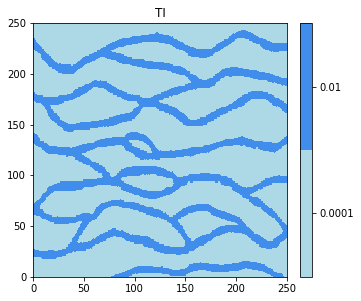

In [3]:
col = ['lightblue', [x/255. for x in ( 65, 141, 235)], 'orange']

plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti, categ=True, categCol=col, title='TI')


##  Set up the DS parameters


In [4]:
# Set input for deesse
# --------------------
# DeeSse input parameters to create the true K field
deesse_input_true = dsi.DeesseInput(
    nx=128,ny=128,nz=1,nv=1,varname='facies',
    nTI=1,TI=ti,
    searchNeighborhoodParameters=dsi.SearchNeighborhoodParameters(rx=40.,ry=40.),
    nneighboringNode=30,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=18,
    nrealization=1)


In [5]:
# DeeSse input parameters to create the realisations for training the ML
deesse_input_realisations = dsi.DeesseInput(
    nx=128,ny=128,nz=1,nv=1,varname='facies',
    nTI=1,TI=ti,
    searchNeighborhoodParameters=dsi.SearchNeighborhoodParameters(rx=40.,ry=40.),
    nneighboringNode=30,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=10)

##  Reference parameter field


********************************************************************************
DEESSE VERSION 3.0 / BUILD NUMBER 20190110
********************************************************************************
DONE


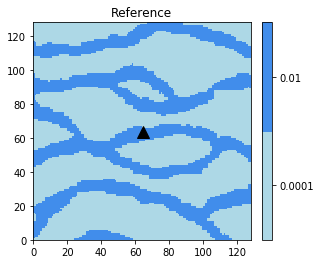

In [6]:
# create the candidate true K field realisations to choose as the ground truth
# well location
wpt = ((64+0.5), 128 - ((64 + 0.5))) # Well location
# perform the DS simulation to create the reference K field
trueKList = dsi.deesseRun(deesse_input_true)
trueK     = trueKList["sim"]
trueK     = img.gatherImages(trueK,varInd=0)
# plot the created reference image
imgplt.drawImage2D(trueK,categCol=col,categ=True,title="Reference")
plt.plot(wpt[0],wpt[1],'k^:',markersize=12)
# write the reference as a GSLIB file
img.writeImageGslib(trueK,filename= ("results/GSLIB/128*128/trueK.gslib"))


##  Perform the MPS Simulations 


In [7]:
# Do DS simulations to create 
# --------------------
doSimul=True

if doSimul:
    simKList  = dsi.deesseRun(deesse_input_realisations)
    simK      = simKList["sim"]
    simK      = img.gatherImages(simK)
    img.writeImageGslib(simK,filename= ("results/GSLIB/128*128/simKAll.gslib"))

    # Write the simulations in seperate GSLIB files
    for i in range(simK.val.shape[0]):
        temp_simK = img.copyImg(simK)
        temp_simK.remove_allvar()
        temp_simK.append_var(simK.val[i,:,:,:])
        img.writeImageGslib(temp_simK,
                            filename="results/GSLIB/128*128/realisations/real_%05.d.gslib" % i)
else:
    # Import the fields
    trueK_filename = 'results/GSLIB/128*128/trueK.gslib'
    simK_filename  = 'results/GSLIB/128*128/simKAll.gslib'
    trueK = img.readImageGslib(trueK_filename, missing_value=MPDS_MISSING_VALUE)
    simK  = img.readImageGslib(simK_filename, missing_value=MPDS_MISSING_VALUE)


********************************************************************************
DEESSE VERSION 3.0 / BUILD NUMBER 20190110
********************************************************************************
DONE


In [8]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 30
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


##  Perform flow Simulations and Save 


In [28]:
if doSimul:
    mf_trueK=forward.Modflow()
    # flow simulation for the reference parmater field
    flow_trueK = img.copyImg(trueK)
    flow_trueK.remove_allvar()
    predTrueK=mf_trueK.predict(model=trueK,imod=0,modelName="forwTrueK")
    flow_trueK.append_var(predTrueK[0])
    img.writeImageGslib(flow_trueK,filename="results/GSLIB/128*128/flow_trueK.gslib" )

    mf_simK=forward.Modflow()
    # flow simulations for realisations
    for i in range(simK.val.shape[0]):
        flow_simK = img.copyImg(simK)
        flow_simK.remove_allvar()
        predSimK=mf_simK.predict(model=simK,imod=i,modelName="forwSimK")
        flow_simK.append_var(predSimK[0])
        img.writeImageGslib(flow_simK,
                            filename="results/GSLIB/128*128/flowRealisations/flow_%05.d.gslib" % i)
        update_progress(i / simK.val.shape[0])
else:
    flow_trueK_filename = 'results/GSLIB/flow_trueK.gslib'
    flow_simK_filename  = 'results/GSLIB/flow_simK.gslib'
    flow_trueK = img.readImageGslib(flow_trueK_filename, missing_value=MPDS_MISSING_VALUE)
    flow_simK  = img.readImageGslib(flow_simK_filename, missing_value=MPDS_MISSING_VALUE)



Progress: [###########################---] 90.0%


##  Display the parameter fields 


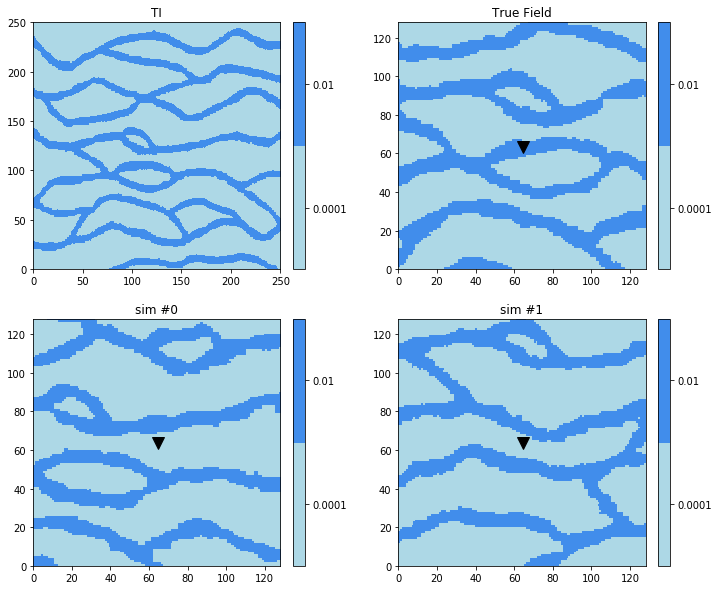

In [29]:
# Draw TI
fig, ax = plt.subplots(2, 2, figsize=(12,10))
plt.subplot(2, 2, 1)
imgplt.drawImage2D(ti,
                   categ=True, categCol=col,
                   title='TI')

plt.subplot(2, 2, 2)
imgplt.drawImage2D(trueK,iv=0,
                   categ=True,  categCol=col,
                   title='True Field')
plt.plot(wpt[0],wpt[1],'v',markersize=12, color="black")
# plt.plot(headsInd[:,0],headsInd[:,1],'.',markersize=14, color="black")


for i in list(range(2)) :
    plt.subplot(2, 2, i+3)
    imgplt.drawImage2D(simK,iv=i,
                       categ=True,  categCol=col,
                       title='sim #{}'.format(i))
    plt.plot(wpt[0],wpt[1],'v',markersize=12, color="black")
    # plt.plot(headsInd[:,0],headsInd[:,1],'.',markersize=14, color="black")
plt.savefig('results/plots/TI_and_realisations.png')


##  Display the Flow Simulations 


/home/local/UNINE.CH/dagasany/anaconda3/envs/flowSimul/lib/python3.7/site-packages/flopy/plot/map.py:438: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)
/home/local/UNINE.CH/dagasany/anaconda3/envs/flowSimul/lib/python3.7/site-packages/flopy/plot/map.py:438: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)
/home/local/UNINE.CH/dagasany/anaconda3/envs/flowSimul/lib/python3.7/site-packages/flopy/plot/map.py:438: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


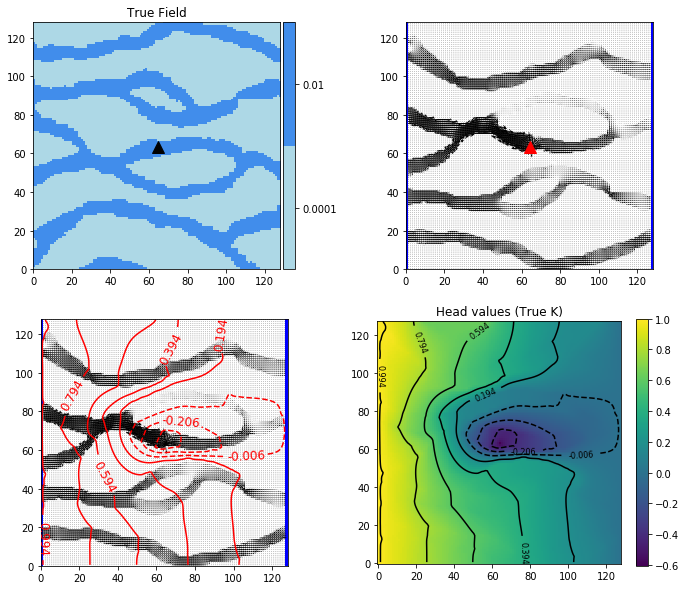

In [33]:

fig_flow, ax = plt.subplots(2, 2, figsize=(12,10))
plt.subplot(2, 2, 1, aspect='equal')
hds = bf.HeadFile(mf_trueK.model_ws+"/"+ mf_trueK.modelname + '.hds')
head = hds.get_data(totim=1.0)
levelsDefine = np.arange(np.min(head),np.max(head),0.2)
extent = (mf_trueK.delr / 2, mf_trueK.Lx - mf_trueK.delr / 2, 
          mf_trueK.Ly - mf_trueK.delc / 2, mf_trueK.delc / 2)
#plt.contour(head[0, :, :], levels=levelsDefine, extent=extent)
# plt.plot(headsInd[:,0],headsInd[:,1],'.',markersize=14, color="black")

imgplt.drawImage2D(trueK,iv=0,
                   categ=True,  categCol=col,
                   title='True Field', colorbar_pad_fraction=0.2)
plt.plot(wpt[0],wpt[1],'k^:',markersize=12)


plt.subplot(2, 2, 2, aspect='equal')
hds = bf.HeadFile( mf_trueK.model_ws+"/"+ mf_trueK.modelname+'.hds')
times = hds.get_times()
head = hds.get_data(totim=times[-1])
levels = np.linspace(0, 10, 5) # contour spacing 

cbb = bf.CellBudgetFile( mf_trueK.model_ws+"/"+ mf_trueK.modelname+'.cbc')
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

modelmap = flopy.plot.ModelMap(model=predTrueK[1], layer=0)
qm = modelmap.plot_ibound()
#cs = modelmap.contour_array(head, levels=levelsDefine, colors='b')
quiver = modelmap.plot_discharge(frf, fff, head=head, istep=5, jstep=6)
#plt.clabel(cs, inline=1, fontsize=12)
plt.plot(wpt[0],wpt[1],'r^:',markersize=12)
# plt.plot(headsInd[:,0],headsInd[:,1],'.',markersize=14, color="red")


modelmap = flopy.plot.ModelMap(model=predTrueK[1], layer=0)
qm = modelmap.plot_ibound()
plt.subplot(2, 2, 3, aspect='equal')
modelmap = flopy.plot.ModelMap(model=predTrueK[1], layer=0)
qm = modelmap.plot_ibound()
cs = modelmap.contour_array(head, levels=levelsDefine, colors='red')
quiver = modelmap.plot_discharge(frf, fff, head=head, istep=5, jstep=6)
plt.clabel(cs, inline=1, fontsize=12)


plt.subplot(2, 2, 4, aspect='equal')
plt.imshow(head[0, ::-1, :], origin="lower")
plt.colorbar()
plt.title("Head values (True K)")
#hds.plot()
#plt.clabel(cs, inline=0, fontsize=8,)
#quadmesh = modelmap.plot_bc('WEL', kper=5, plotAll=True)
contours=plt.contour(head[0, ::-1, :],3, origin="lower", levels=levelsDefine,colors="black") 
plt.clabel(contours, inline=True, fontsize=8)
# plt.plot(headsInd[:,0],headsInd[:,1],'.',markersize=14, color="black")
plt.savefig('results/plots/flow_simulations_trueK.png')

'forwSimK0'